# Jared Mlekush

## <i>K-Means Clustering</i>

When it comes to machine learning there are many new technical terms you must learn.
Supervised and unsupervised learning. Deep vs reinforcement vs machine "learning" - the list goes on.
Today, with me, we will explore and focus on one specific technique which, as the title implies, will be "K-Means Clustering".


<b>So first, what exactly is <i>clustering?</i></b>

Clustering is an unsupervised problem of finding natural groups in the feature space of input data. 
Unsupervised means that we as the users do not have to, for lack of a better term... "supervise" it. 
We allow the model to work on its own to discover patterns and information that was previously undetected.
There are many different clustering algorithms and no single best method for all datasets.


<b>What is <i>K-Means Clustering</i> specifically?</b>

K-Means Clustering is a method of vector quantization. You know exactly what that is right? Yeah, me either.
In layman's terms, it aims to take "n" different points/observations and partition them into "k clusters" (Though I'm not sure if the mathematecians and the like out there would consider that a "rigorous" explanation... just don't tell them eh?). Each observation belongs to the cluster who's centroid has the nearest mean, serving as a "prototype" of the cluster. "K clusters", with each cluster consisting of observations with the nearest mean - "K-Means Clustering". How they came up with a name so clever is beyond me...

![image.png](k_means.png)

<b>Why do we use K-Means?</b>

Implementing K-Means is simple and efficient to do.
Choose how many clusters you want, k, and run it a couple of times.
It is much quicker than many of the other more complicated clustering techniques and often does a good enough job to reduce a lot of data into clusters/ centroids.


<b>Okay Jared, you've sold me on K-Means... how do I go about Implementing it?</b>
- I always have been silver tongued if I do say so myself... Thanks for asking!

1) Select K (usually random) unique points/observations from our feature space X as initial centroids (call those initial centroid indicies 'm')
2) For every data point/observation 'n' in our feature space 'X':
    1) Find the distance and then compute the argmin of distances(n, m)  <-- This finds the closest centroid with respect to each n in the feature space
    2) After finding that closest centroid to n, add n to the cluster associated with that centroid
3) Next, iterate through and calculate new labels, distances, and centroids
    1) Take mean of these newly formed clusters, and use their means as new centroid points for the next iteration/ clustering process
4) Check the mean of the difference between current centroid and previous centroid against some tolerance - if difference is less than the tolerance, stop
    1) All this means is: 
        1) During the first couple iterations, it is likely that our centroid locations will move around a good bit
        2) As we get closer to our final locations for the centroids, the movement of the centroids from iteration to iteraion will/should get smaller and smaller
        3) If we set a threshold/tolerance, we can stop when we see that our new clusters each iteration are hardly any "better" than the last ones


Below is a step by step walkthrough on my own personal adaptaion of K-Means Clustering. It may not be <u>quuuite</u> as pretty as sklearn adaptation, but it did the job sufficiently well for me.
I show 2 different ways to initialize/choose centroids before going on to actually implement the algorithm.

In [72]:
# Packages/imports to be used:
    
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist as dist

In [2]:
def centroid_choice(X, k):
    '''
    Here is a helper function that takes in the data, and gives back to us a list of random 
    indicies to be used for the first set of "k" centroids. These are chosen at random, and as 
    such may not be very spread out. The potential lack of spread may cause the final cluster 
    choices to not be as good as they should/ could be. To aid the alogorithm, a different 
    initialization method may be used- which will be shown next.
    '''
    
    # Indicies tracker
    random_indicies = []
    
    # Iterate through potential indicies until 'k' unique in indicies found.
    while len(random_indicies) < k:
        
        index = random.randint(0, len(X)-1)

        if index not in random_indicies:
            random_indicies.append(index)

    return random_indicies

<b>Different initialization method: <i>K-Means++</i></b>

K-Means++ initializes our initial indicies with a slightly different approach. 
The general idea being:

    1) Pick a single random index of an observation. This gives us our first centroid.
    2) Find the distance from this centroid to all other obesrvations
    3) Create probability distribution using the distance over sum of all the distances
          This boosts the chances of points further away being chosen as next centroid, which is what we want.
    4) Repeat this process again now using the 2 centroids
    5) Take minimum distance to each of the points (comparing the distance to that point from each of the previous centroids.
    6) Use these values to again create a probability distribution.
    7) Repeat until you have "k" initial centroids

In [3]:
def kmeans_plus(X, k):
    
    # Indicies and centroid trackers
    indicies = []
    centroids = []
    
    # First centroid index chosen at random, and kept track of
    index = random.randint(0,len(X))
    indicies.append(index)
    
    # Use list of indicies to "slice" data
    centroids.append(index)
    centroids = X[index, :]
    centroids = np.array(centroids).reshape(1,-1)
    
    for i in range(k-1):
        
        # Centroids in terms of X, and distance from each point in X to all other points
        centroids = X[indicies, :]
        distances = dist(X, centroids, 'euclidean')**2
        
        # Stack horizontally to get "rows" of distances from every centroid, to each point
        row_matrix = np.hstack(distances)
        row_matrix = row_matrix.reshape(-1, len(distances))
        
        
        # Put into Dataframe, take minimum of each column to find closest centroid to that point
        df = pd.DataFrame(row_matrix)
        min_dist = df.min(axis = 0)
        min_dist = np.array(min_dist)
        
        # Create pobability distribution from minimum distances
        prob_of_choice = min_dist/np.sum(min_dist)

        # Randomly choose value from min_dist using probability distribution above as a parameter
        result = np.random.choice(min_dist, p = prob_of_choice)
        
        # Get index of result in min_dist and add to indicie tracker
        ind = np.where(min_dist == result)
        indicies.append(ind[0][0])
            
    return indicies



After getting the initial centroids to start with:

1) Group every point with it's nearest centroid - these are your initial clusters
2) Take the mean of all the clusters, and use that mean as the a new centroid 
3) Repeat this process until the difference between a new cluster and the previous ones is negligible

In [4]:
def kmeans(X: np.ndarray, k: int, centroids=None, max_iter=30, tolerance=1e-2):
   
    
    
    # 1) Select k unique points from X as initial centroids (call those initial centroid indicies 'm')
    
    if centroids == 'kmeans++':
         # Using k++ implementaion
        m = kmeans_plus(X, k)
    else:
        # random centroid implementaion
        m = centroid_choice(X, k)
    

        
    # 2) For every point n in 'X':
    #    - Find distance and then compute the argmin of distance(n, m)  <-- which finds the closest centroid to n.
    #    - After finding closest centroid to n, add n to cluster associated with that centroid
    
    centroids = X[m, :]
    distances = dist(X, centroids, 'euclidean')
    labels = np.array([np.argmin(i) for i in distances])
    
    
    # 3) Iterate through, and calculate new label, distances, and centroids
    for ind in range(max_iter):
        centroids = []

        for i in range(k):
            # Take mean of clusters, and use as new centroid points
            centroid_mean = X[labels == i].mean(axis=0)
            centroids.append(centroid_mean)
     
        centroids = np.vstack(centroids)  # New centroids using the means of each cluster
        
        # Check the mean of the difference between current centroid and previous against a tolerance
        if ind >= 1 and abs(np.mean(centroids - last_centroids)) <= tolerance:
            # Finished if both parameters met
            iterations = ind
            return last_centroids, labels, iterations
        
        # New distances and labels calculated for centroids
        distances = dist(X, centroids, 'euclidean')
        labels = np.array([np.argmin(i) for i in distances])
        
        # Keep track of previous centroids. Used for comparison in next iteration
        last_centroids = copy.deepcopy(centroids)
        iterations = 0


    return last_centroids, labels, iterations

## All Together:

In [ ]:
def centroid_choice(X, k):
    
    # Indicies tracker
    random_indicies = []
    
    # Iterate through potential indicies until 'k' unique in indicies found.
    while len(random_indicies) < k:
        
        index = random.randint(0, len(X)-1)

        if index not in random_indicies:
            random_indicies.append(index)

    return random_indicies




def kmeans_plus(X, k):
    
    # Indicies and centroid trackers
    indicies = []
    centroids = []
    
    # First centroid index chosen at random, and kept track of
    index = random.randint(0,len(X))
    indicies.append(index)
    
    # Use list of indicies to "Slice" data
    centroids.append(index)
    centroids = X[index, :]
    centroids = np.array(centroids).reshape(1,-1)
    
    for i in range(k-1):
        
        # Centroids in terms of X, and distance from each point in X to all other points
        centroids = X[indicies, :]
        distances = dist(X, centroids, 'euclidean')**2
        
        # Stack horizontally to get "rows" of distances from every centroid, to each point
        row_matrix = np.hstack(distances)
        row_matrix = row_matrix.reshape(-1, len(distances))
        
        
        # Put into Dataframe, take minimum of each column to find closest centroid to that point
        df = pd.DataFrame(row_matrix)
        min_dist = df.min(axis = 0)
        min_dist = np.array(min_dist)
        
        # Create pobability distribution from minimum distances
        prob_of_choice = min_dist/np.sum(min_dist)

        # Randomly choose value from min_dist using probability distribution above as a parameter
        result = np.random.choice(min_dist, p = prob_of_choice)
        
        # Get index of result in min_dist and add to indicie tracker
        ind = np.where(min_dist == result)
        indicies.append(ind[0][0])
            
    return indicies




def kmeans(X: np.ndarray, k: int, centroids=None, max_iter=30, tolerance=1e-2):
   
    
    
    # 1) Select k unique points from X as initial centroids (call those initial centroid indicies 'm')
    
    if centroids == 'kmeans++':
         # Using k++ implementaion
        m = kmeans_plus(X, k)
    else:
        # random centroid implementaion
        m = centroid_choice(X, k)
    

        
    # 2) For every point x in 'X':
    #    - Find distance and then compute the argmin of distance(x, m)  <-- which finds the closest centroid to x.
    #    - After finding closest centroid to x, add x to cluster associated with that centroid
    
    centroids = X[m, :]
    distances = dist(X, centroids, 'euclidean')
    labels = np.array([np.argmin(i) for i in distances])
    
    
    # 3) Iterate through, and calculate new label, distances, and centroids
    for ind in range(max_iter):
        centroids = []

        for i in range(k):
            # Take mean of clusters, and use as new centroid points
            centroid_mean = X[labels == i].mean(axis=0)
            centroids.append(centroid_mean)
     
        centroids = np.vstack(centroids)  # New centroids using the means of each cluster
        
        # Check the mean of the difference between current centroid and previous against a tolerance
        if ind >= 1 and abs(np.mean(centroids - last_centroids)) <= tolerance:
            # Finished if both parameters met
            iterations = ind
            return last_centroids, labels, iterations
        
        # New distances and labels calculated for centroids
        distances = dist(X, centroids, 'euclidean')
        labels = np.array([np.argmin(i) for i in distances])
        
        # Keep track of previous centroids. Used for comparison in next iteration
        last_centroids = copy.deepcopy(centroids)
        iterations = 0


    return last_centroids, labels, iterations


<b>Application for K-Means?</b>

- Here is a single application you can utilize K-Means Clustering for: Image compression.
- Take an image and show it with far fewer colors. 

In [161]:
def image_compression(centroids, label, img):
    """
    Here is a helper function that takes in the centroids, labels and image.
    Re-formats in such a way so the program can read the array and print out the image.
    """
    
  
    # Recovering the compressed image by assigning each pixel to its corresponding centroid.
    assign_pixel = centroids[label.astype(int), :]
      
    # Getting back the 3d matrix (row, col, rgb(3))
    image = np.reshape(assign_pixel, (img.shape[0], img.shape[1],
                                                     img.shape[2]))
  
    # Plotting the compressed image.
    plt.imshow(image)
    plt.show()
  

Original Black and white image- unadulterated

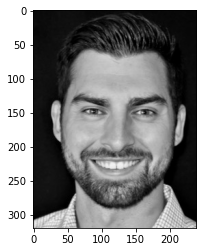

In [166]:
%matplotlib inline
pil_im = Image.open('studmuffin_grey.jpeg', 'r')
plt.imshow(np.asarray(pil_im))
plt.show()

Black and white image using just 2, 4, and 8 shades respectively.

With 2 colors:


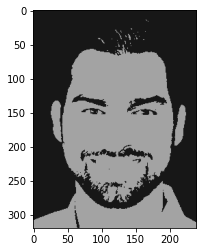

With 4 colors:


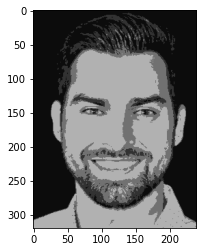

With 8 colors:


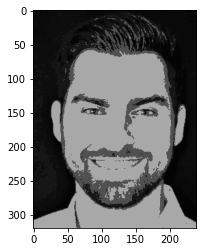

In [135]:
k_list = [2, 4, 8]

for num in k_list:
    print(f'With {num} colors:')
    img = imread('studmuffin_grey.jpeg')
    img = img / 255
    w, h, d = original_shape = tuple(img.shape)
    image_array = np.reshape(img, (w * h, d))
    centroids, labels, iterations = kmeans(image_array, k=num, centroids='kmeans++', max_iter=30)
    image_compression(centroids, labels, img)

Original colored image - unadulterated

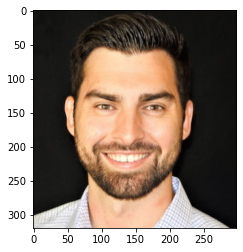

In [168]:
%matplotlib inline
pil_im = Image.open('studmuffin_color.jpeg', 'r')
plt.imshow(np.asarray(pil_im))
plt.show()

Colored image using just 2, 5, 10, and 16 colors respectively

With 2 colors:


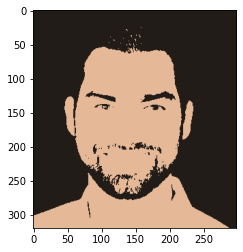

With 5 colors:


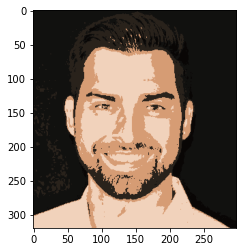

With 10 colors:


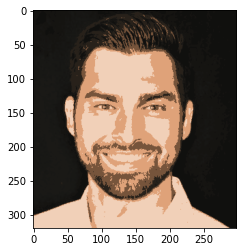

In [142]:
k_list = [2, 5, 10]

for num in k_list:
    print(f'With {num} colors:')
    img = imread('studmuffin_color.jpeg')
    img = img / 255
    w, h, d = original_shape = tuple(img.shape)
    image_array = np.reshape(img, (w * h, d))
    centroids, labels, iterations = kmeans(image_array, k=num, centroids='kmeans++', max_iter=30)
    image_compression(centroids, labels, img)

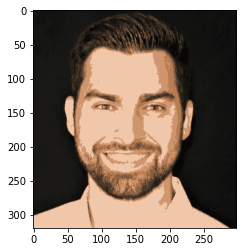

In [148]:
k = 16
img = imread('studmuffin_color.jpeg')
img = img / 255
w, h, d = original_shape = tuple(img.shape)
image_array = np.reshape(img, (w * h, d))
centroids, labels, iterations = kmeans(image_array, k=k, centroids='kmeans++', max_iter=300)
image_compression(centroids, labels, img)

Take Home:
- Clustering is a quick and easy way to take massive amounts of data and shrink it into smaller chunks.
- Sometimes you don't know what to set your 'K' equal to - you can leverage certain techniques such as an elbow plot to help you choose.
- Use clustering when you want to see if there are any natural groups that you may not have known about otherwise.
- If you made it this far, thanks!
